# Supervised patches

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from datetime import datetime
from collections import defaultdict, namedtuple, Counter
import pickle

from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm

In [3]:
sns.set(style="ticks")

In [4]:
class SmallSimpleCNN(nn.Module):
    def __init__(self, patch_size):
        super(SmallSimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.size_after_pool = (patch_size-4)//2
        self.fc1 = nn.Linear(12 * self.size_after_pool * self.size_after_pool, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 12 * self.size_after_pool * self.size_after_pool)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LogisticRegression(nn.Module):
    def __init__(self, patch_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(patch_size * patch_size * 3, 1)
        self.patch_size = patch_size
    
    def forward(self, x):
        x = x.view(-1, self.patch_size * self.patch_size * 3)
        out = self.linear(x)
        return out
    
class SimpleCNN(nn.Module):
    def __init__(self, patch_size):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #W_out = (W_in - F + 2P)/S + 1
        self.size_after_pool = ((patch_size-4)//2 - 4)//2
        self.fc1 = nn.Linear(16 * self.size_after_pool * self.size_after_pool, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * self.size_after_pool * self.size_after_pool)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Parameters

In [17]:
dataset_path = '/home/ath0m/Desktop/medical.h5'

batch_size = 256
num_workers = 4
lr = 0.001
log_interval = 50
epochs = 2

sum_threshold = 42.

### Data loader

In [6]:
import h5py
import random

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler, SequentialSampler, SubsetRandomSampler

In [7]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=32, normalization=None):
        self.original_images = images
        
        self.images = normalization(images) if normalization else images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        patch = torch.from_numpy(patch).float()
        
        return (patch, label)
    
class MedicalSampler(Sampler):
    def __init__(self, positive_indices, negative_indices, num_samples):
        self.num_samples = num_samples
        self.positive = positive_indices
        self.negative = negative_indices

    def __iter__(self):
        self.indices = []
        return self
    
    def __next__(self):
        if len(self.indices) >= self.num_samples:
            raise StopIteration
            
        index = random.choice(self.positive) if torch.rand(1).item() < 0.5 else random.choice(self.negative)
        self.indices.append(index)
        
        return index

    def __len__(self):
        return self.num_samples

class MedicalLoader:
    def __init__(self, dataset_path, patch_size, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_masks = f['train']['masks'][...]

            self.train_positive_indices = f['train']['patches'][str(patch_size)]['positives'][...]
            self.train_negative_indices = f['train']['patches'][str(patch_size)]['negatives'][...]

            self.test_images = f['test']['images'][...]
            self.test_masks = f['test']['masks'][...]

            self.validation_indices = f['validation']['patches'][str(patch_size)]['indices'][...]

        self.train_dataset = MedicalDataset(self.train_images, self.train_masks, patch_size=patch_size)
        self.test_dataset = MedicalDataset(self.test_images, self.test_masks, patch_size=patch_size)
        
    def set_normalization(self, normalization):
        self.train_dataset.images = normalization(self.train_dataset.original_images)
        self.test_dataset.images = normalization(self.test_dataset.original_images)

    def train_loader(self, slice):
        sampler = MedicalSampler(self.train_positive_indices, self.train_negative_indices, int(len(self.train_dataset) * slice))
        loader = DataLoader(self.train_dataset, sampler=sampler, **self.loader_args)
        return loader

    def validation_loader(self, train=False):
        sampler = SubsetRandomSampler([] if train else self.validation_indices)
        loader = DataLoader(self.train_dataset if train else self.test_dataset, sampler=sampler, **self.loader_args)
        return loader

    def test_loader(self, slice=None):
        sampler = SequentialSampler(self.test_dataset) 
        if slice is not None:
            n = len(self.test_dataset)
            sampler = SubsetRandomSampler(np.random.choice(n, int(n * slice)))
        loader = DataLoader(self.test_dataset, sampler=sampler, **self.loader_args)

        return loader

#### Training

In [8]:
def train(model, train_loader, epochs=20):
    losses = []
    
    for epoch in tnrange(epochs):

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_loader)
#         print('[{}, {:5d}] loss: {:.3f}'.format(epoch + 1, i + 1, running_loss))
        losses.append(running_loss)

#     print('Finished Training')
    plt.figure(figsize=(6, 3))
    plt.plot(losses, '.-')
    plt.title('Training loss')
    plt.xlabel('# Epochs')
    plt.ylabel('Loss')
    plt.show()

In [9]:
def test(model, test_loader):
    predictions, targets = [], []

    with torch.no_grad():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.cuda(), labels.cuda()

            output = model(images.float())
            predictions.extend(output.squeeze().tolist())
            targets.extend(labels.cpu().tolist())
    
    plt.figure(figsize=(4, 4))

    fpr, tpr, thresholds = roc_curve(targets, predictions)

#     area = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(area))
#     plt.plot([0, 1], [0, 1], linestyle='--')

#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC')
#     plt.legend(loc="lower right")

#     plt.tight_layout()
#     plt.show()
    
    return fpr, tpr

In [16]:
[v.keys() for v in stats.values()]

[dict_keys([16, 22, 28, 32, 48]), dict_keys([16, 22, 28, 32, 48])]

In [10]:
stats = defaultdict(dict)

In [18]:
for patch_size in [64]: # 16, 22, 28, 32, 48, 
    medical_loader = MedicalLoader(dataset_path, patch_size, batch_size)
    
    train_loader = medical_loader.train_loader(0.001)
    test_loader = medical_loader.test_loader(0.001)
    
    for pname, prototype in [('Regresja logistyczna', LogisticRegression), ('Splotowa sieć neuronowa', SimpleCNN)]:
        model = prototype(patch_size).cuda()

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        print(pname, patch_size)
        train(model, train_loader, epochs=20)
        fpr, tpr = test(model, test_loader)
        
        stats[pname][patch_size] = (fpr, tpr)

Regresja logistyczna 64


OSError: [Errno 12] Cannot allocate memory

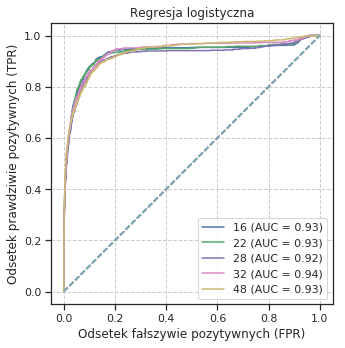

Traceback (most recent call last):
  File "/home/ath0m/.anaconda3/envs/medical/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ath0m/.anaconda3/envs/medical/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ath0m/.anaconda3/envs/medical/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ath0m/.anaconda3/envs/medical/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


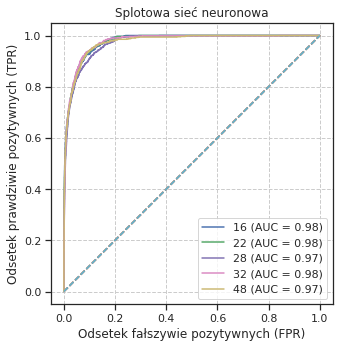

In [20]:
for i, (pname, patch_stat) in enumerate(stats.items(), 1):
    plt.figure(figsize=(5, 5))
    for patch_size, (fpr, tpr) in patch_stat.items():
        area = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(patch_size, area))
        plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlabel('Odsetek fałszywie pozytywnych (FPR)')
    plt.ylabel('Odsetek prawdziwie pozytywnych (TPR)')
    plt.legend(loc="lower right")
    plt.title(pname)
    
    plt.grid(True, ls='--')
    
    
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.show()